## Tweet Preprocessing
Code Adapted From https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e and https://catriscode.com/2021/05/01/tweets-cleaning-with-python/

In [134]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer
from ekphrasis.classes.segmenter import Segmenter
import preprocessor as p
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import resample
from sklearn.preprocessing import normalize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import keras
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten
from keras.layers import Embedding 
from keras.callbacks import ModelCheckpoint 
import os # for commands related to operating system
from sklearn.metrics import roc_auc_score, roc_curve 
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D
from sklearn.preprocessing import LabelEncoder
import csv
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
%matplotlib inline
import time
import gensim
import gensim.downloader
from gensim.models import KeyedVectors
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



[nltk_data] Downloading package wordnet to /Users/anwar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/anwar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/anwar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [135]:
tweets = pd.read_csv("all_tweets.csv").drop(["Unnamed: 0"], axis = 1)

In [136]:
tweets["hashtag"] = tweets["tweet_text"].apply(lambda x: re.findall(r"#(\w+)", x))

In [137]:
# only 2 urls in training set so not relevant
urls = []
for i,v in enumerate(tweets["tweet_text"]):
    parsed_tweet = p.parse(v)
    urls.append(parsed_tweet.urls)
tweets["urls"] = urls
tweets["urls"].value_counts()

[(236:251) => bit.ly/KISSKUBE]                                     1
[(97:145) => pbcgov.org/publicsafety/dem/Pages/Hurricane.aspx]     1
[(57:106) => www.gofundme.com/manage/pv8fwc-hurricane-florence]    1
Name: urls, dtype: int64

In [138]:
tweets.shape

(74227, 7)

In [139]:
#forming a separate feature for cleaned tweets, removing @s, hashtags, numbers, url 
for i,v in enumerate(tweets["tweet_text"]):
    tweets.loc[i,"clean_text"] = p.clean(str(v))


In [140]:
# lowercase and remove digits
tweets.clean_text = tweets.clean_text.astype(str).str.replace('\d+', '')
tweets.clean_text = tweets.clean_text.str.lower()


/var/folders/mh/n6v5vl_n5vv4x_wsgv7ctzcr0000gn/T/ipykernel_36815/1987246793.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets.clean_text = tweets.clean_text.astype(str).str.replace('\d+', '')


In [141]:
# remove punctuation and nonalphanumeric characters
for i,v in enumerate(tweets["clean_text"]):
    tweets.loc[i,"clean_text"] = re.sub('[()!?]', ' ', v)
    tweets.loc[i,"clean_text"] = re.sub('\[.*?\:;]',' ', v)
    tweets.loc[i,"clean_text"] = re.sub("[^a-z0-9]", ' ', v)

In [142]:
# tokenize, stem, and lemmatize words to split into list of words and 
# extract prefixes common regardless of plurality and tense
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()
stemmer = PorterStemmer()
def lemmatize_text(text):
    #return [(stemmer.stem(lemmatizer.lemmatize(w))) for w in w_tokenizer.tokenize((text))]
    return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]

tokenized_tweets = []
for i,v in enumerate(tweets["clean_text"]):
    tokenized_tweets.append(lemmatize_text(v))
    

In [143]:
tweets["tokenized_tweets"] = tokenized_tweets

In [144]:
# remove stopwords 
stop_words = set(stopwords.words('english'))
tweets['tokenized_tweets'] = tweets['tokenized_tweets'].apply(lambda x: [item for item in x if item not in stop_words])


In [145]:
tweet_length = []
for i,v in enumerate(tweets["tokenized_tweets"]):
    tweet_length.append(len(v))
tweets["tweet_length"] = tweet_length

12.183706737440554


(array([4.0900e+03, 1.8634e+04, 2.7914e+04, 9.6150e+03, 7.4940e+03,
        4.2820e+03, 1.9440e+03, 2.3100e+02, 2.0000e+01, 3.0000e+00]),
 array([ 0. ,  4.5,  9. , 13.5, 18. , 22.5, 27. , 31.5, 36. , 40.5, 45. ]),
 <BarContainer object of 10 artists>)

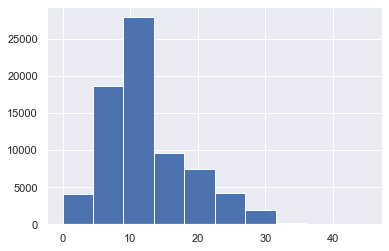

In [146]:
print(np.mean(tweets.tweet_length))
plt.hist(tweets.tweet_length)

In [147]:
tokens = []
for i,v in enumerate(tweets["tokenized_tweets"]):
    for x in v: 
        tokens.append(x)

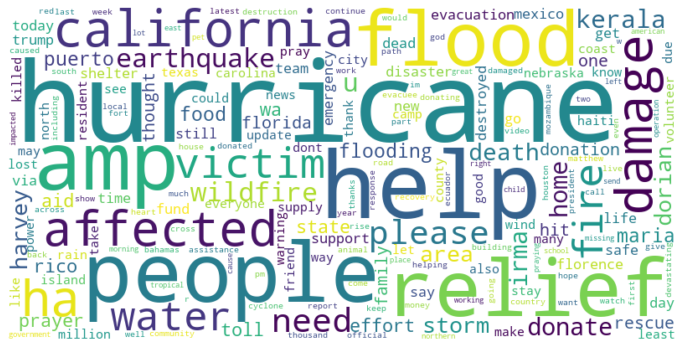

In [148]:
fdist = FreqDist(tokens)
#WordCloud
wc = WordCloud(width=800, height=400, max_words=200, background_color="white").generate_from_frequencies(fdist)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [149]:
#run both types of stopwords

25.073749584118886


(array([3.5991e+04, 5.0000e+01, 1.4000e+01, 7.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 1.61670e+03, 3.23240e+03, 4.84810e+03, 6.46380e+03,
        8.07950e+03, 9.69520e+03, 1.13109e+04, 1.29266e+04, 1.45423e+04,
        1.61580e+04]),
 <BarContainer object of 10 artists>)

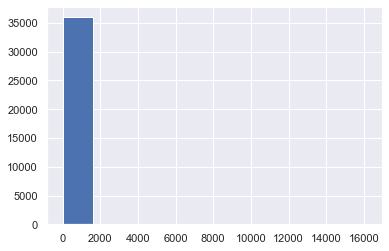

In [150]:
token_counts = pd.DataFrame([fdist], index = ["count"]).T
print(np.mean(token_counts["count"]))
plt.hist(token_counts["count"])

11.814824794212349


(array([ 2396., 15615., 19341., 17640.,  6244.,  6131.,  4483.,  1668.,
          632.,    77.]),
 array([ 0. ,  3.6,  7.2, 10.8, 14.4, 18. , 21.6, 25.2, 28.8, 32.4, 36. ]),
 <BarContainer object of 10 artists>)

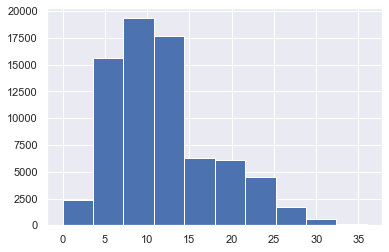

In [151]:
infrequent_tokens = list(token_counts[token_counts["count"] < 3].index)
stopwords_extended = stopwords.words('english') + infrequent_tokens
stop_words = set(stopwords_extended)
tweets['tokenized_tweets_clean'] = tweets['tokenized_tweets'].apply(lambda x: [item for item in x if item not in stop_words])
tweet_length = []
for i,v in enumerate(tweets["tokenized_tweets_clean"]):
    tweet_length.append(len(v))
tweets["tweet_length_clean"] = tweet_length
print(np.mean(tweets["tweet_length_clean"]))
plt.hist(tweets["tweet_length_clean"])

66.58914198936978


(array([1.3093e+04, 5.0000e+01, 1.4000e+01, 7.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([3.00000e+00, 1.61850e+03, 3.23400e+03, 4.84950e+03, 6.46500e+03,
        8.08050e+03, 9.69600e+03, 1.13115e+04, 1.29270e+04, 1.45425e+04,
        1.61580e+04]),
 <BarContainer object of 10 artists>)

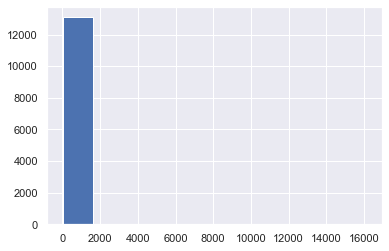

In [152]:
clean_tokens = []
for i,v in enumerate(tweets["tokenized_tweets_clean"]):
    for x in v: 
        clean_tokens.append(x)
fdist_clean = FreqDist(clean_tokens)
token_counts_clean = pd.DataFrame([fdist_clean], index = ["count"]).T
print(np.mean(token_counts_clean["count"]))
plt.hist(token_counts_clean["count"])

In [153]:
token_counts_clean.shape

(13170, 1)

In [154]:
for i,v in enumerate(tweets["tokenized_tweets_clean"]): 
    tweets.loc[i,"clean_text_final"] = " ".join(v)

### Rebalancing Data Set

In [166]:
tweets["clean_labels"] = tweets["class_label"].map({"missing_or_found_people":"harmed_persons_and_evacuations",
                                                    "injured_or_dead_people":"harmed_persons_and_evacuations",
                                                    "displaced_people_and_evacuations": "harmed_persons_and_evacuations",
                                                   "rescue_volunteering_or_donation_effort": "rescue_volunteering_or_donation_effort",
                                                   "other_relevant_information" : "other_relevant_information",
                                                   "sympathy_and_support" : "sympathy_and_support",
                                                   "infrastructure_and_utility_damage": "infrastructure_and_utility_damage",
                                                   "not_humanitarian": "not_humanitarian",
                                                   "caution_and_advice": "caution_and_advice",
                                                   "requests_or_urgent_needs" : "requests_or_urgent_needs"})


In [167]:
label_counts = dict(tweets["clean_labels"].value_counts())
label_counts

{'rescue_volunteering_or_donation_effort': 20849,
 'other_relevant_information': 11848,
 'harmed_persons_and_evacuations': 10949,
 'sympathy_and_support': 8499,
 'infrastructure_and_utility_damage': 8046,
 'not_humanitarian': 6145,
 'caution_and_advice': 5298,
 'requests_or_urgent_needs': 2593}

In [169]:
all_tweets_cleaned = tweets[['tweet_id','tweet_text','class_label','event_name',
        'event_type', 'tweet_length_clean', 'clean_text_final','clean_labels']]

#all_tweets_cleaned.to_csv('all_tweets_cleaned.csv')
all_tweets_cleaned

,tweet_id,tweet_text,class_label,event_name,event_type,tweet_length_clean,clean_text_final,clean_labels
0,1.061652e+18,Smoking ruins and a mobile DNA lab: California...,injured_or_dead_people,California Wildfires 2018,wildfire,12,smoking ruin mobile dna lab california wildfir...,harmed_persons_and_evacuations
1,1.064599e+18,"California’s utility, PG&amp;E was responsible...",other_relevant_information,California Wildfires 2018,wildfire,29,california utility pg amp e wa responsible fir...,other_relevant_information
2,1.061240e+18,At least 9 dead in California wildfires as ten...,injured_or_dead_people,California Wildfires 2018,wildfire,17,least dead california wildfire ten thousand fl...,harmed_persons_and_evacuations
3,1.063609e+18,RT @WGNNews: At least 66 dead in California wi...,injured_or_dead_people,California Wildfires 2018,wildfire,7,least dead california wildfire name missing list,harmed_persons_and_evacuations
4,1.064157e+18,25K - + homeless &amp; from the #DeranfgedOran...,injured_or_dead_people,California Wildfires 2018,wildfire,21,k homeless amp couldve le destructive would ra...,harmed_persons_and_evacuations
...,...,...,...,...,...,...,...,...
74222,8.704278e+17,RT @jscarto: Severe flooding in #SriLanka seen...,caution_and_advice,Sri Lanka Floods 2017,flood,4,severe flooding seen data,caution_and_advice
74223,8.702856e+17,"Sri Lankans, young and old without and race di...",sympathy_and_support,Sri Lanka Floods 2017,flood,15,sri lankans young old without race difference ...,sympathy_and_support
74224,8.745305e+17,#PhotoOfTheDay: Capt. McPherson of #USSLakeEri...,other_relevant_information,Sri Lanka Floods 2017,flood,7,capt greets child well restoration site relief,other_relevant_information
74225,8.714161e+17,RT @sulorammohan: Medical aid for #Flood vict...,requests_or_urgent_needs,Sri Lanka Floods 2017,flood,4,medical aid victim covered,requests_or_urgent_needs


In [159]:
classes = list(pd.DataFrame(tweets["clean_labels"].value_counts()).index)
classes.remove("requests_or_urgent_needs")
sample_size = label_counts['caution_and_advice']
resampled_tweets = tweets[tweets["clean_labels"] == "requests_or_urgent_needs"]
resampled_tweets = pd.concat([resampled_tweets,resample(resampled_tweets,replace=True,
                                                        n_samples=sample_size-label_counts['requests_or_urgent_needs'],random_state=0)])

for label in classes:
    class_tweets = tweets[tweets["clean_labels"] == label]
    resampled_tweets = pd.concat([resampled_tweets,
                                  resample(class_tweets,replace=False,n_samples=sample_size,random_state=0)])

resampled_tweets = resample(resampled_tweets,replace=False,n_samples=resampled_tweets.shape[0],random_state=0)


### Sentiment Features

In [25]:
sid_obj = SentimentIntensityAnalyzer()
pos = []
neu = []
neg = []
for i,v in enumerate(resampled_tweets["clean_text_final"]):
    sent = sid_obj.polarity_scores(v)
    pos.append(sent['pos'])
    neu.append(sent['neu'])
    neg.append(sent['neg'])

In [26]:
corpus = list(resampled_tweets["clean_text_final"])
train_percent = 0.7
dev_percent = 0.1
train_cutoff = int(train_percent*len(corpus))
dev_cutoff = int((train_percent + dev_percent)*len(corpus))
labels = list(resampled_tweets.clean_labels)

In [27]:
dev_cutoff

33907

In [28]:
n = resampled_tweets.shape[0]

### TFIDF Modeling 

Code adapted from https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [188]:
def get_tfidf_scores(model, start, end, step, ngram):
    scores = []
    iteration = 0
    for i in np.arange(start,end,step):
        tfidf = TfidfVectorizer(max_features = i, ngram_range = (1, ngram)) 
        tfidf.fit(corpus)
        tfidf_features = tfidf.transform(corpus)
        tfidf_model = model
        tfidf_model.fit(tfidf_features[0 : train_cutoff], labels[0 : train_cutoff])
        tfidf_prediction = tfidf_model.predict(tfidf_features[train_cutoff : dev_cutoff])
        scores.append(precision_recall_fscore_support(labels[train_cutoff : dev_cutoff], tfidf_prediction, 
                                                            average = 'weighted', zero_division = True)[2])
        iteration = iteration + 1
        if ngram == 1: 
            print(iteration)
    scores_td = pd.DataFrame(np.arange(start,end,step), columns = ["max_features"])
    scores_td["score"] = scores
    return scores_td



def plot_model_features(model, start, end, step, ngram):    
    scores_td = get_tfidf_scores(model, start, end, step, 1)
    l1, = plt.plot(scores_td["max_features"], scores_td["score"], label = "unigrams")
    plt.title(str(model))
    plt.xlabel("max_features")
    plt.ylabel("F1-score")
    if ngram == 2: 
        scores_td_2 = get_tfidf_scores(model, start, end, step, 2)
        l2, = plt.plot(scores_td_2["max_features"], scores_td_2["score"], label = "unigrams and bigrams")
        leg = plt.legend(loc='lower center')
        plt.show()
    else: 
        leg = plt.legend(loc='lower center')
        plt.show()
    #return scores_td


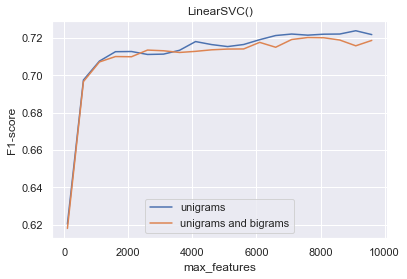

,max_features,score
0,100,0.620291
1,600,0.697442
2,1100,0.707592
3,1600,0.712623
4,2100,0.712724
5,2600,0.711141
6,3100,0.711321
7,3600,0.713377
8,4100,0.718049
9,4600,0.716435


In [169]:
plot_model_features(LinearSVC(),100,10000,500,2)

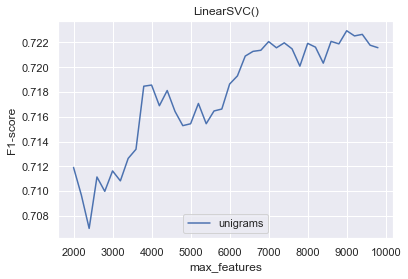

,max_features,score
0,2000,0.711913
1,2200,0.709680
2,2400,0.706989
3,2600,0.711141
4,2800,0.709983
5,3000,0.711631
6,3200,0.710827
7,3400,0.712640
8,3600,0.713377
9,3800,0.718467


In [174]:
plot_model_features(LinearSVC(),2000,10000,200,1) # 7000 unigrams 

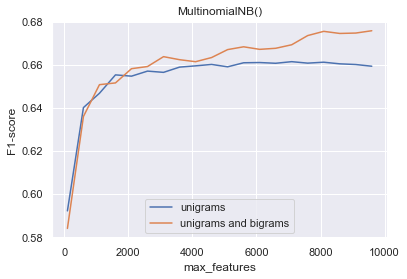

,max_features,score
0,100,0.592194
1,600,0.640162
2,1100,0.646810
3,1600,0.655356
4,2100,0.654754
5,2600,0.657103
6,3100,0.656521
7,3600,0.658960
8,4100,0.659543
9,4600,0.660202


In [175]:
plot_model_features(MultinomialNB(),100,10000,500,2) # 8000 unigrams and bigrams

In [29]:
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn.svm import SVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


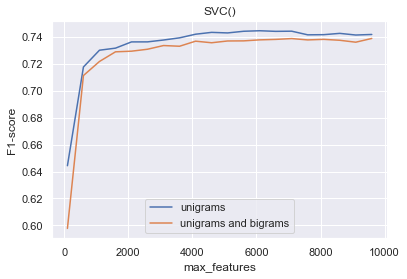

In [187]:

plot_model_features(SVC(),100,10000,500,2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


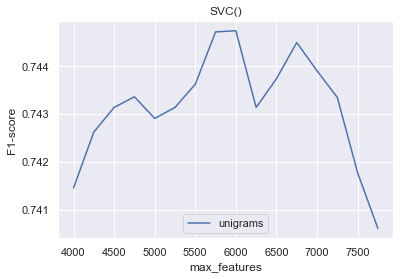

In [189]:
plot_model_features(SVC(),4000,8000,250,1) #6000 unigrams 

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


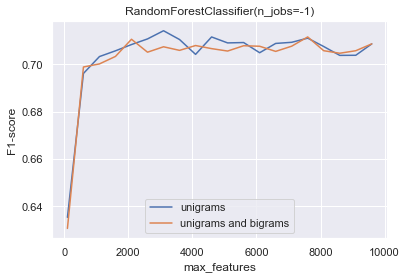

In [191]:
patch_sklearn()
from sklearn.ensemble import RandomForestClassifier
plot_model_features(RandomForestClassifier(n_jobs = -1),100,10000,500,2)

1
2
3
4
5
6
7
8


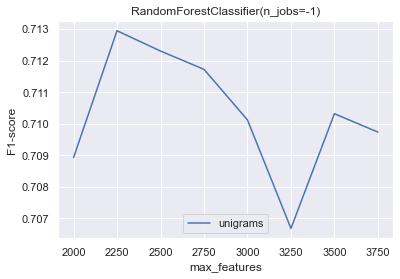

In [192]:
plot_model_features(RandomForestClassifier(n_jobs = -1),2000,4000,250,1) # 2250 unigrams

In [169]:
def get_best_scores(max_features, ngram, model): 
    tfidf = TfidfVectorizer(max_features = i, ngram_range = (1, ngram)) 
    tfidf.fit(corpus)
    tfidf_features = tfidf.transform(corpus)
    tfidf_model = model
    tfidf_model.fit(tfidf_features[0 : train_cutoff], labels[0 : train_cutoff])
    tfidf_prediction = tfidf_model.predict(tfidf_features[train_cutoff : dev_cutoff])
    prf = precision_recall_fscore_support(labels[train_cutoff : dev_cutoff], tfidf_prediction, 
                                                                average = 'weighted', zero_division = True)
    acc = accuracy_score(labels[train_cutoff : dev_cutoff], tfidf_prediction)
    prf = np.array(prf[:3])
    acc = np.array(acc).reshape(1,)
    return np.concatenate((prf,acc), axis = 0)

In [170]:
results = pd.DataFrame(index = ['Linear SVC - 7000 unigrams', 'SVC - 6000 unigrams', 'MultinomialNB - 8000 unigrams and bigrams', 'Random Forest - 2250 unigrams'], 
          columns = ['Precision', 'Recall', 'F1 score', 'Accuracy'])
results.loc['Linear SVC - 7000 unigrams'] = get_best_scores(7000, 1, LinearSVC())

In [171]:
results.loc['SVC - 6000 unigrams'] = get_best_scores(6000, 1, SVC())

In [172]:
results.loc['MultinomialNB - 8000 unigrams and bigrams'] = get_best_scores(8000, 2, MultinomialNB())

In [173]:
results.loc['Random Forest - 2250 unigrams'] = get_best_scores(2250, 1, RandomForestClassifier(n_jobs = -1))

In [174]:
results = results.sort_values(['F1 score'], ascending = False)
results 

,Precision,Recall,F1 score,Accuracy
SVC - 6000 unigrams,0.745792,0.741213,0.742225,0.741213
Linear SVC - 7000 unigrams,0.718861,0.725879,0.721638,0.725879
Random Forest - 2250 unigrams,0.704891,0.717858,0.708859,0.717858
MultinomialNB - 8000 unigrams and bigrams,0.6888,0.700873,0.687621,0.700873


In [175]:
def get_train_scores(max_features, ngram, model): 
    tfidf = TfidfVectorizer(max_features = i, ngram_range = (1, ngram)) 
    tfidf.fit(corpus)
    tfidf_features = tfidf.transform(corpus)
    tfidf_model = model
    tfidf_model.fit(tfidf_features[0 : train_cutoff], labels[0 : train_cutoff])
    tfidf_prediction = tfidf_model.predict(tfidf_features[0 : train_cutoff])
    prf = precision_recall_fscore_support(labels[0 : train_cutoff], tfidf_prediction, 
                                                                average = 'weighted', zero_division = True)
    acc = accuracy_score(labels[0 : train_cutoff], tfidf_prediction)
    prf = np.array(prf[:3])
    acc = np.array(acc).reshape(1,)
    return np.concatenate((prf,acc), axis = 0)

In [176]:
results_train = pd.DataFrame(index = ['Linear SVC - 7000 unigrams', 'SVC - 6000 unigrams', 'MultinomialNB - 8000 unigrams and bigrams', 'Random Forest - 2250 unigrams'], 
          columns = ['Train Precision', 'Train Recall', 'Train F1 score', 'Train Accuracy'])
results_train.loc['Linear SVC - 7000 unigrams'] = get_train_scores(7000, 1, LinearSVC())

In [177]:
results_train.loc['SVC - 6000 unigrams'] = get_train_scores(6000, 1, SVC())

In [178]:
results_train.loc['MultinomialNB - 8000 unigrams and bigrams'] = get_train_scores(8000, 2, MultinomialNB())

In [179]:
results_train.loc['Random Forest - 2250 unigrams'] = get_train_scores(2250, 1, RandomForestClassifier(n_jobs = -1))

In [180]:
results_train = results_train.sort_values(['Train F1 score'], ascending = False)
results_train

,Train Precision,Train Recall,Train F1 score,Train Accuracy
Random Forest - 2250 unigrams,0.999024,0.999023,0.999023,0.999023
SVC - 6000 unigrams,0.950795,0.950721,0.950487,0.950721
Linear SVC - 7000 unigrams,0.916531,0.916846,0.915966,0.916846
MultinomialNB - 8000 unigrams and bigrams,0.81736,0.814682,0.808912,0.814682


In [181]:
results.columns = ['Val Precision', 'Val Recall', 'Val F1 score', 'Val Accuracy']

### Hyperparameter Tuning for SVC Using TFIDF

In [118]:
tfidf = TfidfVectorizer(max_features = 6000, ngram_range = (1, 1)) 
tfidf.fit(corpus)
tfidf_features = tfidf.transform(corpus)

Hyperparameter tuning code adapted from https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

In [214]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'poly']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(tfidf_features[0 : train_cutoff], labels[0 : train_cutoff])

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.687 total time=   6.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.689 total time=   5.5s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.674 total time=   5.2s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.684 total time=   5.6s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.688 total time=   5.2s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.624 total time=   6.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.623 total time=   6.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.608 total time=   6.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.615 total time=   6.6s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.621 total time=   6.7s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.687 total time=   5.2s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

[CV 2/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.126 total time=   7.3s
[CV 3/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.126 total time=   7.5s
[CV 4/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.126 total time=   7.4s
[CV 5/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.126 total time=   7.5s
[CV 1/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.721 total time=   5.9s
[CV 2/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.718 total time=   5.6s
[CV 3/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.706 total time=   5.1s
[CV 4/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.718 total time=   5.3s
[CV 5/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.711 total time=   5.1s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.566 total time=   6.8s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.564 total time=   6.9s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.556 total time=   6.9s
[CV 4/5] END .......C=1, gam

[CV 4/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.561 total time=   7.3s
[CV 5/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.561 total time=   6.9s
[CV 1/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.126 total time=   6.9s
[CV 2/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.126 total time=   7.6s
[CV 3/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.126 total time=   6.8s
[CV 4/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.126 total time=  11.1s
[CV 5/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.126 total time=   7.6s
[CV 1/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.682 total time=   7.6s
[CV 2/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.683 total time=   7.1s
[CV 3/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.674 total time=   7.0s
[CV 4/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.678 total time=   7.1s
[CV 5/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.683 total time=   7.0s
[CV 1/5] END ....C=10, gamma

[CV 1/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.728 total time=   8.5s
[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.729 total time=   8.4s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.717 total time=   8.4s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.728 total time=   8.4s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.724 total time=   8.7s
[CV 1/5] END ......C=1000, gamma=1, kernel=poly;, score=0.654 total time=  11.3s
[CV 2/5] END ......C=1000, gamma=1, kernel=poly;, score=0.659 total time=  11.0s
[CV 3/5] END ......C=1000, gamma=1, kernel=poly;, score=0.635 total time=   9.9s
[CV 4/5] END ......C=1000, gamma=1, kernel=poly;, score=0.641 total time=  11.3s
[CV 5/5] END ......C=1000, gamma=1, kernel=poly;, score=0.646 total time=  11.0s
[CV 1/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.654 total time=  12.0s
[CV 2/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.659 total time=  13.0s
[CV 3/5] END ..C=1000, gamma

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=3)

In [216]:
print(grid.best_params_) 3 #{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)


In [38]:
tuned_classifier = SVC(C=10, gamma=1, kernel = 'rbf')
tuned_classifier.fit(tfidf_features[0 : train_cutoff], labels[0 : train_cutoff])
tuned_predictions = tuned_classifier.predict(tfidf_features[train_cutoff : dev_cutoff])
tuned_scores = precision_recall_fscore_support(labels[train_cutoff : dev_cutoff], tuned_predictions, 
                                                                average = 'weighted', zero_division = True)
acc_tuned = accuracy_score(labels[train_cutoff : dev_cutoff], tuned_predictions)

In [197]:
results.loc['SVC - 6000 unigrams HP Tuned'] = np.concatenate((np.array(tuned_scores[:3]),
                                                              np.array(acc_tuned).reshape(1,)), axis = 0)



In [190]:
tuned_predictions_train = tuned_classifier.predict(tfidf_features[0 : train_cutoff])
tuned_scores_train = precision_recall_fscore_support(labels[0 : train_cutoff], tuned_predictions_train, 
                                                                average = 'weighted', zero_division = True)
acc_tuned_train = accuracy_score(labels[0 : train_cutoff], tuned_predictions_train)

In [191]:
results_train.loc['SVC - 6000 unigrams HP Tuned'] = np.concatenate((np.array(tuned_scores_train[:3]),
                                                              np.array(acc_tuned_train).reshape(1,)), axis = 0)


### Analysis with Additional Features

In [30]:
# Code from from https://www.stackvidhya.com/how-to-normalize-data-between-0-and-1-range/#:~:text=You%20can%20normalize%20data%20between,min(data))%20.
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


In [119]:
length_tweets = np.append(np.asarray(tfidf_features.todense()),
                          NormalizeData(np.array(resampled_tweets.tweet_length_clean).reshape(n,1)),axis = 1)

In [31]:
sentiments = np.append(np.append(np.array(pos).reshape(n,1),np.array(neu).reshape(n,1), axis = 1),
          np.array(neg).reshape(n,1), axis = 1)

In [120]:
sentiment_tweets = np.append(length_tweets, sentiments, axis = 1)

In [121]:
patch_sklearn()
sentiment_svc = SVC(C=10, gamma=1, kernel = 'rbf')
sentiment_svc.fit(sentiment_tweets[0 : train_cutoff], labels[0 : train_cutoff])

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


SVC(C=10, gamma=1)

In [44]:
sentiment_predictions = sentiment_svc.predict(sentiment_tweets[train_cutoff : dev_cutoff])
sentiment_scores = precision_recall_fscore_support(labels[train_cutoff : dev_cutoff], sentiment_predictions, 
                                                                average = 'weighted', zero_division = True)
acc_sentiment = accuracy_score(labels[train_cutoff : dev_cutoff], sentiment_predictions)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [198]:
results.loc['SVC - 6000 unigrams + sentiments HP Tuned'] = np.concatenate((np.array(sentiment_scores[:3]),
                                                              np.array(acc_sentiment).reshape(1,)), axis = 0)

In [193]:
sentiment_predictions_train = tuned_classifier.predict(tfidf_features[0 : train_cutoff])
sentiment_scores_train = precision_recall_fscore_support(labels[0 : train_cutoff], sentiment_predictions_train, 
                                                                average = 'weighted', zero_division = True)
acc_sentiment_train = accuracy_score(labels[0 : train_cutoff], sentiment_predictions_train)


In [194]:
results_train.loc['SVC - 6000 unigrams + sentiments HP Tuned'] = np.concatenate((np.array(sentiment_scores_train[:3]),
                                                              np.array(acc_sentiment_train).reshape(1,)), axis = 0)

In [206]:
results_tfid = pd.concat([results_train,results], axis = 1).sort_values(['Val F1 score'], ascending = False)
results_tfid

,Train Precision,Train Recall,Train F1 score,Train Accuracy,Val Precision,Val Recall,Val F1 score,Val Accuracy
SVC - 6000 unigrams + sentiments HP Tuned,0.998653,0.998652,0.998652,0.998652,0.749515,0.747346,0.747964,0.747346
SVC - 6000 unigrams HP Tuned,0.998653,0.998652,0.998652,0.998652,0.748636,0.745223,0.746263,0.745223
SVC - 6000 unigrams,0.950795,0.950721,0.950487,0.950721,0.745792,0.741213,0.742225,0.741213
Linear SVC - 7000 unigrams,0.916531,0.916846,0.915966,0.916846,0.718861,0.725879,0.721638,0.725879
Random Forest - 2250 unigrams,0.999024,0.999023,0.999023,0.999023,0.704891,0.717858,0.708859,0.717858
MultinomialNB - 8000 unigrams and bigrams,0.81736,0.814682,0.808912,0.814682,0.6888,0.700873,0.687621,0.700873


In [115]:
from sklearn import metrics

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'caution_and_advice'),
  Text(1.5, 0, 'sympathy_and_support'),
  Text(2.5, 0, 'harmed_persons_and_evacuations'),
  Text(3.5, 0, 'other_relevant_information'),
  Text(4.5, 0, 'requests_or_urgent_needs'),
  Text(5.5, 0, 'not_humanitarian'),
  Text(6.5, 0, 'infrastructure_and_utility_damage'),
  Text(7.5, 0, 'rescue_volunteering_or_donation_effort')])

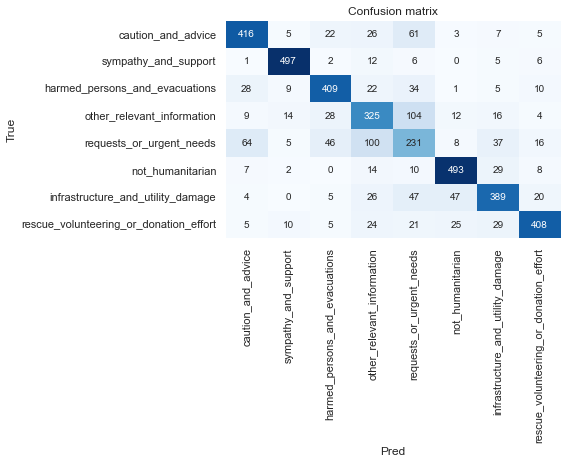

In [242]:
cm = metrics.confusion_matrix(labels[train_cutoff : dev_cutoff], sentiment_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
all_classes = list(pd.DataFrame(resampled_tweets["clean_labels"].value_counts()).index)
ax.set(xlabel="Pred", ylabel="True", xticklabels=all_classes, 
       yticklabels=all_classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

### Word Embeddings

code adapted from https://medium.com/@dcameronsteinke/tf-idf-vs-word-embedding-a-comparison-and-code-tutorial-5ba341379ab0

In [32]:
glove = gensim.downloader.load('glove-twitter-200')

In [50]:
# code adpated from https://medium.com/@dcameronsteinke/tf-idf-vs-word-embedding-a-comparison-and-code-tutorial-5ba341379ab0
array_length = 20 * 200
embedding_features_final = pd.DataFrame()
start = time.time()
for i in np.arange(0,len(corpus),100):
    if i == 42300: 
        end = 42385
    else: 
        end = i + 100
    embedding_features = pd.DataFrame()
    for document in corpus[i:end]:
        # Saving the first 20 words of the document as a sequence
        words = text_to_word_sequence(document)[0:20] 

        # Retrieving the vector representation of each word and 
        # appending it to the feature vector 
        feature_vector = []
        for word in words:
            try:
                feature_vector = np.append(feature_vector, 
                                           np.array(glove[word]))
            except KeyError:
                # In the event that a word is not included in our 
                # dictionary skip that word
                pass
        # If the text has less then 20 words, fill remaining vector with
        # zeros
        zeroes_to_add = array_length - len(feature_vector)
        feature_vector = np.append(feature_vector, 
                                   np.zeros(zeroes_to_add)
                                   ).reshape((1,-1))

        # Append the document feature vector to the feature table
        embedding_features = pd.concat([embedding_features, 
                                         pd.DataFrame(feature_vector)], axis = 0)
    embedding_features_final = pd.concat([embedding_features_final, embedding_features], axis = 0)
end = round(time.time()-start,2)
print("This process took",end,"seconds.")

This process took 255.36 seconds.


In [52]:
embedding_features_final

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.058481,0.319050,-0.432100,-0.312980,0.234530,0.276730,0.59625,-0.111400,-0.007097,-0.138720,...,0.05858,0.37605,0.24818,-0.083894,1.0295,0.12997,0.75542,0.035673,-0.2264,-1.038
0,0.149530,0.154200,-0.386940,-0.239400,-0.294520,0.018088,1.30430,-0.017222,0.098416,0.009079,...,0.00000,0.00000,0.00000,0.000000,0.0000,0.00000,0.00000,0.000000,0.0000,0.000
0,0.080782,0.358320,-0.263870,-0.267070,0.177930,-0.631730,0.20853,-0.068034,0.048625,-0.244390,...,0.00000,0.00000,0.00000,0.000000,0.0000,0.00000,0.00000,0.000000,0.0000,0.000
0,0.122480,0.043629,-0.496370,-0.666880,0.020655,0.434110,0.54882,-0.689310,-0.213860,0.256320,...,0.00000,0.00000,0.00000,0.000000,0.0000,0.00000,0.00000,0.000000,0.0000,0.000
0,0.176050,0.524030,-0.065835,0.059083,0.101940,0.188860,1.12890,0.279790,0.379200,0.720350,...,0.00000,0.00000,0.00000,0.000000,0.0000,0.00000,0.00000,0.000000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.077444,0.258970,0.064159,-0.083965,-0.021368,0.266910,0.36573,-0.221060,-0.113490,0.085575,...,0.00000,0.00000,0.00000,0.000000,0.0000,0.00000,0.00000,0.000000,0.0000,0.000
0,-0.094364,0.257770,-0.324060,-0.647730,-0.008840,-0.371580,0.30375,-0.276980,0.156850,0.072737,...,0.00000,0.00000,0.00000,0.000000,0.0000,0.00000,0.00000,0.000000,0.0000,0.000
0,0.325410,-0.237940,-0.641290,0.145040,-0.005762,-0.130550,0.25836,0.426400,0.328720,-0.383820,...,0.00000,0.00000,0.00000,0.000000,0.0000,0.00000,0.00000,0.000000,0.0000,0.000
0,-0.055253,0.027004,0.057241,-0.432590,0.195700,-0.743760,0.53673,-0.499040,-0.169520,0.308950,...,0.00000,0.00000,0.00000,0.000000,0.0000,0.00000,0.00000,0.000000,0.0000,0.000


In [33]:
lengths = pd.DataFrame(NormalizeData(resampled_tweets.tweet_length_clean)).reset_index().drop(["index"], axis = 1).rename(columns={"tweet_length_clean": 0})
extra_features = pd.concat([pd.DataFrame(sentiments),lengths], axis = 1)

In [52]:
expanded_embeddings = pd.concat([embedding_features_final.reset_index().drop(["index"], axis = 1), extra_features], axis = 1)
expanded_embeddings.columns = list(np.arange(0,4004))

In [53]:
def fit_model(classifier,df): 
    start = time.time()
    classifier.fit(df[0 : train_cutoff], labels[0 : train_cutoff])
    prediction = classifier.predict(df[train_cutoff : dev_cutoff])
    end = round(time.time()-start,2)
    print("This process took",end,"seconds.")
    prf = precision_recall_fscore_support(labels[train_cutoff : dev_cutoff], prediction, 
                                                                average = 'weighted', zero_division = True)
    acc = accuracy_score(labels[train_cutoff : dev_cutoff], prediction)
    prf = np.array(prf[:3])
    acc = np.array(acc).reshape(1,)
    return np.concatenate((prf,acc), axis = 0)

In [54]:
results_we = pd.DataFrame(index = ['Linear SVC', 'SVC','MultinomialNB','Random Forest'], 
          columns = ['Precision', 'Recall', 'F1 score', 'Accuracy'])

In [55]:
results_we.loc['Linear SVC'] = fit_model(LinearSVC(), embedding_features_final)

/Users/anwar/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


This process took 558.0 seconds.


In [56]:
results_we.loc['SVC'] = fit_model(SVC(), embedding_features_final)

This process took 174.22 seconds.


In [57]:
results_we.loc['MultinomialNB'] = fit_model(MultinomialNB(), NormalizeData(embedding_features_final))

/Users/anwar/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/anwar/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


This process took 9.4 seconds.


In [58]:
results_we.loc['Random Forest'] = fit_model(RandomForestClassifier(n_jobs = -1), embedding_features_final)

This process took 36.93 seconds.


In [60]:
results_we = results_we.sort_values(['F1 score'], ascending = False)

In [63]:
results_we.index = ['Glove SVC', 'Glove Random Forest', 'Glove Linear SVC', 'Glove MultinomialNB']

In [34]:
def fit_model_train(classifier,df): 
    start = time.time()
    classifier.fit(df[0 : train_cutoff], labels[0 : train_cutoff])
    prediction = classifier.predict(df[0 : train_cutoff])
    end = round(time.time()-start,2)
    print("This process took",end,"seconds.")
    prf = precision_recall_fscore_support(labels[0 : train_cutoff], prediction, 
                                                                average = 'weighted', zero_division = True)
    acc = accuracy_score(labels[0 : train_cutoff], prediction)
    prf = np.array(prf[:3])
    acc = np.array(acc).reshape(1,)
    return np.concatenate((prf,acc), axis = 0)

In [208]:
results_we_train = pd.DataFrame(index = ['Glove SVC', 'Glove Random Forest', 
                                         'Glove Linear SVC', 'Glove MultinomialNB'], 
          columns = ['Train Precision', 'Train Recall', 'Train F1 score', 'Train Accuracy'])

In [209]:
results_we_train.loc['Glove Linear SVC'] = fit_model_train(LinearSVC(), embedding_features_final)

/Users/anwar/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


This process took 647.88 seconds.


In [210]:
results_we_train.loc['Glove SVC'] = fit_model_train(SVC(), embedding_features_final)

This process took 465.72 seconds.


In [211]:
results_we_train.loc['Glove MultinomialNB'] = fit_model_train(MultinomialNB(), 
                                                              NormalizeData(embedding_features_final))

/Users/anwar/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/anwar/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


This process took 8.74 seconds.


In [212]:
results_we_train.loc['Glove Random Forest'] = fit_model_train(RandomForestClassifier(n_jobs = -1), 
                                                              embedding_features_final)

This process took 37.95 seconds.


In [217]:
results_train = pd.concat([results_train, results_we_train], axis = 0)

Hyperparameter tuning code adapted from https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

In [41]:
from sklearn.model_selection import GridSearchCV
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear', 'rbf', 'poly']}
 
grid_we = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid_we.fit(embedding_features_final[0 : 4000], labels[0 : 4000])

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.569 total time=   4.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.586 total time=   3.2s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.573 total time=   3.5s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.564 total time=   3.3s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.556 total time=   3.4s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.131 total time=   4.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   4.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   3.8s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   4.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   4.1s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.500 total time=   4.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

[CV 2/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.547 total time=   4.0s
[CV 3/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.559 total time=   4.0s
[CV 4/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.571 total time=   4.0s
[CV 5/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.557 total time=   3.8s
[CV 1/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.560 total time=   3.3s
[CV 2/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.578 total time=   3.3s
[CV 3/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.574 total time=   3.3s
[CV 4/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.560 total time=   3.4s
[CV 5/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.551 total time=   3.4s
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.583 total time=   4.2s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.571 total time=   3.7s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.570 total time=   3.7s
[CV 4/5] END ......C=1, gamm

[CV 4/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.145 total time=   4.2s
[CV 5/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.154 total time=   4.2s
[CV 1/5] END .....C=100, gamma=0.1, kernel=poly;, score=0.500 total time=   4.0s
[CV 2/5] END .....C=100, gamma=0.1, kernel=poly;, score=0.500 total time=   3.8s
[CV 3/5] END .....C=100, gamma=0.1, kernel=poly;, score=0.504 total time=   3.9s
[CV 4/5] END .....C=100, gamma=0.1, kernel=poly;, score=0.495 total time=   3.8s
[CV 5/5] END .....C=100, gamma=0.1, kernel=poly;, score=0.489 total time=   3.9s
[CV 1/5] END ..C=100, gamma=0.01, kernel=linear;, score=0.560 total time=   3.5s
[CV 2/5] END ..C=100, gamma=0.01, kernel=linear;, score=0.578 total time=   3.4s
[CV 3/5] END ..C=100, gamma=0.01, kernel=linear;, score=0.574 total time=   3.3s
[CV 4/5] END ..C=100, gamma=0.01, kernel=linear;, score=0.560 total time=   3.5s
[CV 5/5] END ..C=100, gamma=0.01, kernel=linear;, score=0.551 total time=   3.3s
[CV 1/5] END .....C=100, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=3)

In [43]:
print(grid_we.best_params_)  #{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
print(grid_we.best_estimator_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.001)


In [66]:
best_we_scores = fit_model(SVC(C=10, gamma=0.001, kernel = 'rbf'), embedding_features_final)
best_we_scores

This process took 180.97 seconds.


array([0.68572039, 0.68789809, 0.6860284 , 0.68789809])

In [67]:
best_we_scores_expanded = fit_model(SVC(C=10, gamma=0.001, kernel = 'rbf'), expanded_embeddings)
best_we_scores_expanded

This process took 198.27 seconds.


array([0.68688986, 0.68954942, 0.68752293, 0.68954942])

In [68]:
results_we.loc["Glove SVC Tuned"] = best_we_scores
results_we.loc["Glove SVC Tuned Sentiments"] = best_we_scores_expanded

In [220]:
results_train.loc["Glove SVC Tuned"] = fit_model_train(SVC(C=10, gamma=0.001, kernel = 'rbf'),
                                                       embedding_features_final)

This process took 395.74 seconds.


In [221]:
results_train.loc["Glove SVC Tuned Sentiments"] = fit_model_train(SVC(C=10, gamma=0.001, kernel = 'rbf'), 
                                                            expanded_embeddings)

This process took 428.85 seconds.


In [35]:
tfidf = TfidfVectorizer(max_features = 6000, ngram_range = (1, 1)) 
tfidf.fit(corpus)
tfidf_features = np.asarray(tfidf.transform(corpus).todense())

In [36]:
tfidf_df = pd.DataFrame(tfidf_features)
tfidf_df.columns = list(tfidf.get_feature_names_out())
tfidf_df

,aa,aaa,aameen,aaron,ab,abaco,abacos,abandon,abandoned,abbott,...,zanu,zayn,zealand,zero,zim,zimbabwe,zimbabwean,zinke,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# code adapted from https://medium.com/@dcameronsteinke/tf-idf-vs-word-embedding-a-comparison-and-code-tutorial-5ba341379ab0
array_length = 20*200
embedding_features_final_tfidf = pd.DataFrame()
start = time.time()
tweet_num = 0
for i in np.arange(0,len(corpus),100):
    if i == 42300: 
        end = 42385
    else: 
        end = i + 100
    embedding_features = pd.DataFrame()
    for document in corpus[i:end]:
        # Saving the first 20 words of the document as a sequence
        words = text_to_word_sequence(document)[0:20] 

        # Retrieving the vector representation of each word and 
        # appending it to the feature vector 
        feature_vector = []
        tfidf_sum = 0
        for word in words:
            try:
                feature_vector = np.append(feature_vector, 
                                           np.array(glove[word]*tfidf_df[word][tweet_num]))
                tfidf_sum = tfidf_sum + tfidf_df[word][tweet_num]
            except KeyError:
                # In the event that a word is not included in our 
                # dictionary skip that word
                pass
        # If the text has less then 20 words, fill remaining vector with
        # zeros
        feature_vector = np.array(feature_vector)/tfidf_sum
        zeroes_to_add = array_length - len(feature_vector)
        feature_vector = np.append(feature_vector, 
                                   np.zeros(zeroes_to_add)
                                   ).reshape((1,-1))

        # Append the document feature vector to the feature table
        embedding_features = pd.concat([embedding_features, 
                                         pd.DataFrame(feature_vector)], axis = 0)
        tweet_num = tweet_num + 1
    embedding_features_final_tfidf = pd.concat([embedding_features_final_tfidf, embedding_features], axis = 0)
end = round(time.time()-start,2)
print("This process took",end,"seconds.")

This process took 288.17 seconds.


In [42]:
expanded_embeddings_tfidf = pd.concat([embedding_features_final_tfidf.reset_index().drop(["index"], axis = 1), 
                                       extra_features], axis = 1)
expanded_embeddings_tfidf.columns = list(np.arange(0,4004))

In [75]:
best_we_scores_tfidf = fit_model(SVC(C=10, gamma=0.001, kernel = 'rbf'), embedding_features_final_tfidf)
best_we_scores_tfidf

This process took 265.89 seconds.


array([0.5958442 , 0.58244869, 0.58127635, 0.58244869])

In [76]:
best_we_scores_expanded_tfidf = fit_model(SVC(C=10, gamma=0.001, kernel = 'rbf'), expanded_embeddings_tfidf)
best_we_scores_expanded_tfidf

This process took 219.98 seconds.


array([0.60295283, 0.60014154, 0.5985343 , 0.60014154])

In [77]:
results_we.loc["Glove SVC TFIDF Tuned"] = best_we_scores_tfidf
results_we.loc["Glove SVC TFIDF Tuned Sentiments"] = best_we_scores_expanded_tfidf

In [78]:
# results_we.to_csv("we_results.csv")

In [84]:
results_traditional = pd.concat([results, results_we], axis = 0).sort_values(['F1 score'], ascending = False)

In [43]:
results_train.loc["Glove SVC TFIDF Tuned"] = fit_model_train(SVC(C=10, gamma=0.001, kernel = 'rbf'),
                                                             embedding_features_final_tfidf)

This process took 789.46 seconds.


In [44]:
results_train.loc["Glove SVC TFIDF Tuned Sentiments"] = fit_model_train(SVC(C=10, gamma=0.001, kernel = 'rbf'), 
                                                                     expanded_embeddings_tfidf)

This process took 3189.13 seconds.


In [46]:
results_train

,Train Precision,Train Recall,Train F1 score,Train Accuracy
Random Forest - 2250 unigrams,0.999024,0.999023,0.999023,0.999023
SVC - 6000 unigrams,0.950795,0.950721,0.950487,0.950721
Linear SVC - 7000 unigrams,0.916531,0.916846,0.915966,0.916846
MultinomialNB - 8000 unigrams and bigrams,0.817360,0.814682,0.808912,0.814682
SVC - 6000 unigrams HP Tuned,0.998653,0.998652,0.998652,0.998652
SVC - 6000 unigrams + sentiments HP Tuned,0.998653,0.998652,0.998652,0.998652
Glove SVC,0.894301,0.894229,0.893731,0.894229
Glove Random Forest,0.999124,0.999124,0.999124,0.999124
Glove Linear SVC,0.892124,0.893724,0.892475,0.893724
Glove MultinomialNB,0.577439,0.566570,0.570255,0.566570


### Neural Networks

code adapted from https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35

In [47]:
le = LabelEncoder()
y = le.fit_transform(labels)

In [104]:
label_transform = dict(zip(np.arange(0,8,1), le.inverse_transform(np.arange(0,8,1))))

In [48]:
vocab_size = 10000
embedding_dim = 200
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8
num_epochs = 10

In [53]:
train_emb = np.array(embedding_features_final).reshape(len(corpus),20,200)

In [90]:
def plot_graphs(history, string):
    plt.plot(list(range(1,num_epochs + 1)), history.history[string])
    plt.plot(list(range(1,num_epochs + 1)), history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [54]:
output_dir = '/Users/anwar/Desktop/SML310/Final Project'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [96]:
modelcheckpoint_lstm1 = ModelCheckpoint(filepath=output_dir+
                                  "/weights_lstm1.{epoch:02d}.hdf5")
    
model_lstm_1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(embedding_dim),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_lstm_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history_model_lstm_1 = model_lstm_1.fit(train_emb[0 : train_cutoff], y[0 : train_cutoff], 
                    epochs=num_epochs, validation_data=(train_emb[train_cutoff:], y[train_cutoff:]), 
                                        verbose=True, callbacks=[modelcheckpoint_lstm1])

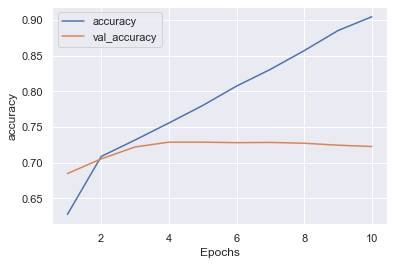

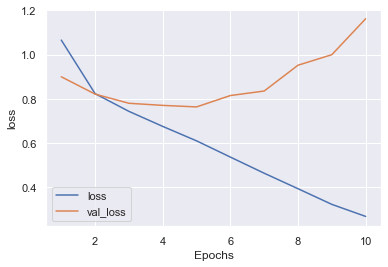

In [180]:
plot_graphs(history_model_lstm_1, "accuracy")
plot_graphs(history_model_lstm_1, "loss") # 3 epochs

In [55]:
model_lstm_1 = keras.models.load_model(output_dir+"/weights_lstm1.03.hdf5")

2022-05-03 12:25:27.323290: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [122]:
pred_lstm_1 = np.argmax(model_lstm_1.predict(train_emb[train_cutoff : dev_cutoff]), axis = 1)
prf = precision_recall_fscore_support(y[train_cutoff : dev_cutoff], pred_lstm_1, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[train_cutoff : dev_cutoff], pred_lstm_1)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_lstm_1 = np.concatenate((prf,acc), axis = 0)
scores_lstm_1

array([0.7249647 , 0.72540694, 0.72309238, 0.72540694])

In [56]:
pred_lstm_1_train = np.argmax(model_lstm_1.predict(train_emb[0 : train_cutoff]), axis = 1)
prf = precision_recall_fscore_support(y[0 : train_cutoff], pred_lstm_1_train, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[0 : train_cutoff], pred_lstm_1_train)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_lstm_1_train = np.concatenate((prf,acc), axis = 0)
scores_lstm_1_train

array([0.7637468 , 0.7637859 , 0.76142472, 0.7637859 ])

In [ ]:
modelcheckpoint_lstm2 = ModelCheckpoint(filepath=output_dir+
                                  "/weights_lstm2.{epoch:02d}.hdf5")

model_lstm_2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(embedding_dim, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(embedding_dim),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_lstm_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history_model_lstm_2 = model_lstm_2.fit(train_emb[0 : train_cutoff], y[0 : train_cutoff], 
                    epochs=num_epochs, validation_data=(train_emb[train_cutoff:], y[train_cutoff:]), 
                                        verbose=True, callbacks=[modelcheckpoint_lstm2])

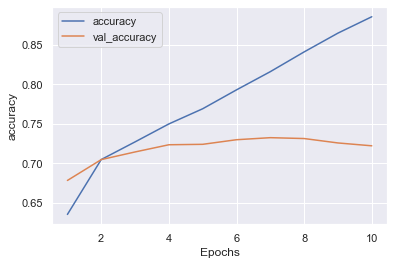

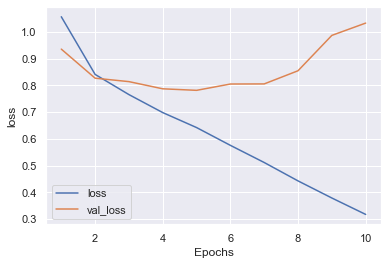

In [181]:
plot_graphs(history_model_lstm_2, "accuracy")
plot_graphs(history_model_lstm_2, "loss")

# 4 epochs

In [57]:
model_lstm_2 = keras.models.load_model(output_dir+"/weights_lstm2.04.hdf5")

In [123]:
pred_lstm_2 = np.argmax(model_lstm_2.predict(train_emb[train_cutoff : dev_cutoff]), axis = 1)
prf = precision_recall_fscore_support(y[train_cutoff : dev_cutoff], pred_lstm_2, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[train_cutoff : dev_cutoff], pred_lstm_2)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_lstm_2 = np.concatenate((prf,acc), axis = 0)
scores_lstm_2

array([0.72620539, 0.72800189, 0.72168919, 0.72800189])

In [58]:
pred_lstm_2_train = np.argmax(model_lstm_2.predict(train_emb[0 : train_cutoff]), axis = 1)
prf = precision_recall_fscore_support(y[0 : train_cutoff], pred_lstm_2_train, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[0 : train_cutoff], pred_lstm_2_train)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_lstm_2_train = np.concatenate((prf,acc), axis = 0)
scores_lstm_2_train

array([0.77094149, 0.77238102, 0.76684314, 0.77238102])

In [ ]:
modelcheckpoint_bilstm1 = ModelCheckpoint(filepath=output_dir+
                                  "/weights_bilstm1.{epoch:02d}.hdf5")
model_bilstm_1 = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model_bilstm_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history_model_bilstm_1 = model_bilstm_1.fit(train_emb[0 : train_cutoff], y[0 : train_cutoff], 
                    epochs=num_epochs, validation_data=(train_emb[train_cutoff:], y[train_cutoff:]), 
                                            verbose=True, callbacks=[modelcheckpoint_bilstm1])

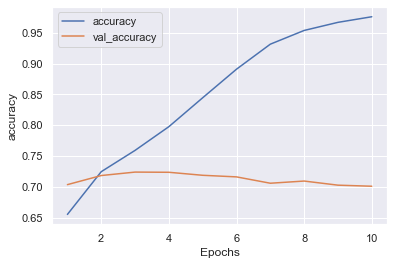

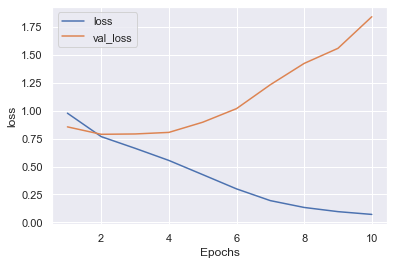

In [182]:
plot_graphs(history_model_bilstm_1, "accuracy")
plot_graphs(history_model_bilstm_1, "loss") # 3 epochs 

In [59]:
model_bilstm_1 = keras.models.load_model(output_dir+"/weights_bilstm1.03.hdf5")

In [124]:
pred_bilstm_1 = np.argmax(model_bilstm_1.predict(train_emb[train_cutoff : dev_cutoff]), axis = 1)
prf = precision_recall_fscore_support(y[train_cutoff : dev_cutoff], pred_bilstm_1, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[train_cutoff : dev_cutoff], pred_bilstm_1)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_bilstm_1 = np.concatenate((prf,acc), axis = 0)
scores_bilstm_1

array([0.7231586 , 0.73036093, 0.72066752, 0.73036093])

In [60]:
pred_bilstm_1_train = np.argmax(model_bilstm_1.predict(train_emb[0 : train_cutoff]), axis = 1)
prf = precision_recall_fscore_support(y[0 : train_cutoff], pred_bilstm_1_train, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[0 : train_cutoff], pred_bilstm_1_train)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_bilstm_1_train = np.concatenate((prf,acc), axis = 0)
scores_bilstm_1_train

array([0.80112248, 0.80291897, 0.79563843, 0.80291897])

In [ ]:
modelcheckpoint_bilstm2 = ModelCheckpoint(filepath=output_dir+
                                  "/weights_bilstm2.{epoch:02d}.hdf5")
model_bilstm_2 = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model_bilstm_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history_model_bilstm_2 = model_bilstm_2.fit(train_emb[0 : train_cutoff], y[0 : train_cutoff], 
                    epochs=num_epochs, validation_data=(train_emb[train_cutoff:], y[train_cutoff:]), 
                                            verbose=True, callbacks=[modelcheckpoint_bilstm2])

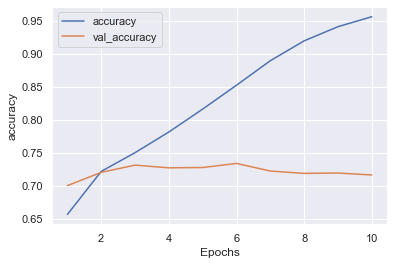

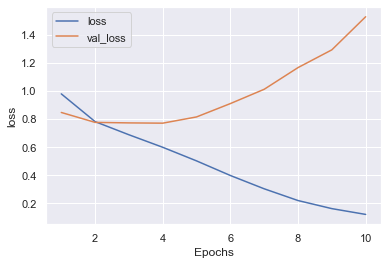

In [183]:
plot_graphs(history_model_bilstm_2, "accuracy")
plot_graphs(history_model_bilstm_2, "loss")

In [61]:
model_bilstm_2 = keras.models.load_model(output_dir+"/weights_bilstm2.03.hdf5")

In [125]:
pred_bilstm_2 = np.argmax(model_bilstm_2.predict(train_emb[train_cutoff : dev_cutoff]), axis = 1)
prf = precision_recall_fscore_support(y[train_cutoff : dev_cutoff], pred_bilstm_2, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[train_cutoff : dev_cutoff], pred_bilstm_2)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_bilstm_2 = np.concatenate((prf,acc), axis = 0)
scores_bilstm_2

array([0.73303363, 0.73814579, 0.72893333, 0.73814579])

In [62]:
pred_bilstm_2_train = np.argmax(model_bilstm_2.predict(train_emb[0 : train_cutoff]), axis = 1)
prf = precision_recall_fscore_support(y[0 : train_cutoff], pred_bilstm_2_train, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[0 : train_cutoff], pred_bilstm_2_train)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_bilstm_2_train = np.concatenate((prf,acc), axis = 0)
scores_bilstm_2_train

array([0.7891902 , 0.79236888, 0.78327531, 0.79236888])

### RNN Generated Embeddings

code adapted from https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35

In [63]:
train_articles = corpus[0: train_cutoff]
train_labels = y[0: train_cutoff]

validation_articles = corpus[train_cutoff : dev_cutoff]
validation_labels = y[train_cutoff : dev_cutoff]

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, 
                                  padding=padding_type, truncating=trunc_type)

In [64]:
train_labels = train_labels.reshape(train_padded.shape[0],1)
validation_labels = validation_labels.reshape(validation_padded.shape[0],1)

In [244]:
modelcheckpoint_lstm1_em = ModelCheckpoint(filepath=output_dir+
                                  "/weights_lstm1_em.{epoch:02d}.hdf5")
model_lstm1_em = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences = True)),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.LSTM(embedding_dim),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model_lstm1_em.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_model_lstm1_em = model_lstm1_em.fit(train_padded, train_labels, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels), 
                             verbose=True, callbacks=[modelcheckpoint_lstm1_em])


Epoch 1/10
928/928 [==============================] - 76s 80ms/step - loss: 2.0798 - accuracy: 0.1218 - val_loss: 2.0797 - val_accuracy: 0.1208
Epoch 2/10
928/928 [==============================] - 73s 78ms/step - loss: 2.0796 - accuracy: 0.1212 - val_loss: 2.0799 - val_accuracy: 0.1208
Epoch 3/10
928/928 [==============================] - 71s 77ms/step - loss: 2.0796 - accuracy: 0.1243 - val_loss: 2.0797 - val_accuracy: 0.1196
Epoch 4/10
928/928 [==============================] - 71s 77ms/step - loss: 2.0796 - accuracy: 0.1244 - val_loss: 2.0798 - val_accuracy: 0.1196
Epoch 5/10
928/928 [==============================] - 71s 76ms/step - loss: 2.0796 - accuracy: 0.1241 - val_loss: 2.0798 - val_accuracy: 0.1196
Epoch 6/10
928/928 [==============================] - 71s 77ms/step - loss: 2.0796 - accuracy: 0.1250 - val_loss: 2.0796 - val_accuracy: 0.1196
Epoch 7/10
928/928 [==============================] - 71s 76ms/step - loss: 2.0796 - accuracy: 0.1241 - val_loss: 2.0796 - val_accuracy:

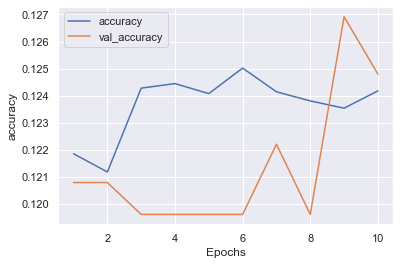

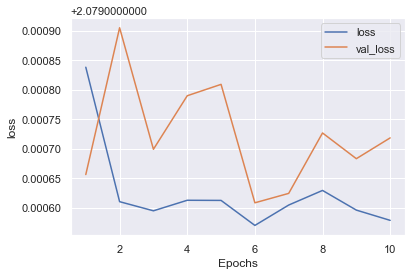

In [245]:
plot_graphs(history_model_lstm1_em, "accuracy")
plot_graphs(history_model_lstm1_em, "loss") # 7 epochs

In [65]:
model_lstm1_em = keras.models.load_model(output_dir+"/weights_lstm1_em.07.hdf5")

In [126]:
pred_lstm1_em = np.argmax(model_lstm1_em.predict(validation_padded), axis = 1)
prf = precision_recall_fscore_support(y[train_cutoff : dev_cutoff], pred_lstm1_em, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[train_cutoff : dev_cutoff], pred_lstm1_em)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_lstm_1_em = np.concatenate((prf,acc), axis = 0)
scores_lstm_1_em

array([0.89273387, 0.12219863, 0.02661295, 0.12219863])

In [66]:
pred_lstm1_em_train = np.argmax(model_lstm1_em.predict(train_padded), axis = 1)
prf = precision_recall_fscore_support(y[0:train_cutoff], pred_lstm1_em_train, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[0:train_cutoff], pred_lstm1_em_train)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_lstm_1_em_train = np.concatenate((prf,acc), axis = 0)
scores_lstm_1_em_train

array([0.89033443, 0.12538762, 0.02794069, 0.12538762])

In [241]:
modelcheckpoint_lstm2_em = ModelCheckpoint(filepath=output_dir+
                                  "/weights_lstm2_em.{epoch:02d}.hdf5")
model_lstm2_em = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(embedding_dim, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.LSTM(embedding_dim),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model_lstm2_em.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_model_lstm2_em = model_lstm2_em.fit(train_padded, train_labels, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels), 
                             verbose=True, callbacks=[modelcheckpoint_lstm2_em])

Epoch 1/10
928/928 [==============================] - 103s 100ms/step - loss: 2.0798 - accuracy: 0.1214 - val_loss: 2.0796 - val_accuracy: 0.1208
Epoch 2/10
928/928 [==============================] - 91s 98ms/step - loss: 2.0796 - accuracy: 0.1233 - val_loss: 2.0797 - val_accuracy: 0.1248
Epoch 3/10
928/928 [==============================] - 91s 98ms/step - loss: 2.0796 - accuracy: 0.1270 - val_loss: 2.0798 - val_accuracy: 0.1222
Epoch 4/10
928/928 [==============================] - 90s 97ms/step - loss: 2.0796 - accuracy: 0.1224 - val_loss: 2.0795 - val_accuracy: 0.1248
Epoch 5/10
928/928 [==============================] - 90s 97ms/step - loss: 2.0796 - accuracy: 0.1235 - val_loss: 2.0796 - val_accuracy: 0.1208
Epoch 6/10
928/928 [==============================] - 90s 97ms/step - loss: 2.0806 - accuracy: 0.1235 - val_loss: 2.0798 - val_accuracy: 0.1196
Epoch 7/10
928/928 [==============================] - 91s 98ms/step - loss: 2.0796 - accuracy: 0.1238 - val_loss: 2.0797 - val_accurac

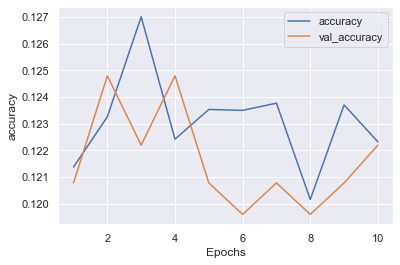

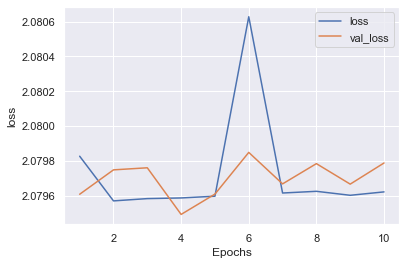

In [242]:
plot_graphs(history_model_lstm2_em, "accuracy")
plot_graphs(history_model_lstm2_em, "loss")

In [67]:
model_lstm2_em = keras.models.load_model(output_dir+"/weights_lstm2_em.02.hdf5")

In [127]:
pred_lstm2_em = np.argmax(model_lstm2_em.predict(validation_padded), axis = 1)
prf = precision_recall_fscore_support(y[train_cutoff : dev_cutoff], pred_lstm2_em, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[train_cutoff : dev_cutoff], pred_lstm2_em)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_lstm_2_em = np.concatenate((prf,acc), axis = 0)
scores_lstm_2_em

array([0.89077986, 0.12479358, 0.02769119, 0.12479358])

In [68]:
pred_lstm2_em_train = np.argmax(model_lstm2_em.predict(train_padded), axis = 1)
prf = precision_recall_fscore_support(y[0:train_cutoff], pred_lstm2_em_train, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[0:train_cutoff], pred_lstm2_em_train)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_lstm_2_em_train = np.concatenate((prf,acc), axis = 0)
scores_lstm_2_em_train

array([0.89003155, 0.1257921 , 0.02811114, 0.1257921 ])

In [228]:
modelcheckpoint_bilstm1_em = ModelCheckpoint(filepath=output_dir+
                                  "/weights_bilstm1_em.{epoch:02d}.hdf5")
model_bilstm1_em = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    #tf.keras.layers.LSTM(embedding_dim, return_sequences = True),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model_bilstm1_em.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_model_bilstm1_em = model_bilstm1_em.fit(train_padded, train_labels, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels), 
                             verbose=True, callbacks=[modelcheckpoint_bilstm1_em])


Epoch 1/10
928/928 [==============================] - 86s 90ms/step - loss: 1.0600 - accuracy: 0.6232 - val_loss: 0.8364 - val_accuracy: 0.7195
Epoch 2/10
928/928 [==============================] - 84s 91ms/step - loss: 0.6620 - accuracy: 0.7711 - val_loss: 0.7778 - val_accuracy: 0.7325
Epoch 3/10
928/928 [==============================] - 81s 88ms/step - loss: 0.4969 - accuracy: 0.8288 - val_loss: 0.8569 - val_accuracy: 0.7174
Epoch 4/10
928/928 [==============================] - 81s 88ms/step - loss: 0.3733 - accuracy: 0.8733 - val_loss: 0.9680 - val_accuracy: 0.7181
Epoch 5/10
928/928 [==============================] - 82s 88ms/step - loss: 0.2775 - accuracy: 0.9061 - val_loss: 1.1142 - val_accuracy: 0.7098
Epoch 6/10
928/928 [==============================] - 82s 89ms/step - loss: 0.2137 - accuracy: 0.9276 - val_loss: 1.2923 - val_accuracy: 0.7011
Epoch 7/10
928/928 [==============================] - 83s 89ms/step - loss: 0.1585 - accuracy: 0.9482 - val_loss: 1.5953 - val_accuracy:

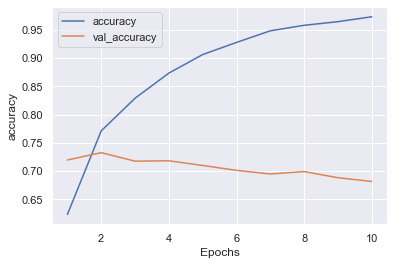

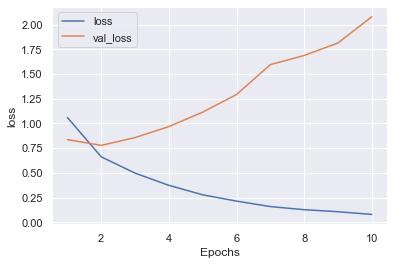

In [229]:
plot_graphs(history_model_bilstm1_em, "accuracy")
plot_graphs(history_model_bilstm1_em, "loss")

In [69]:
model_bilstm1_em = keras.models.load_model(output_dir+"/weights_bilstm1_em.02.hdf5")

In [128]:
pred_bilstm1_em = np.argmax(model_bilstm1_em.predict(validation_padded), axis = 1)
prf = precision_recall_fscore_support(y[train_cutoff : dev_cutoff], pred_bilstm1_em, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[train_cutoff : dev_cutoff], pred_bilstm1_em)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_bilstm_1_em = np.concatenate((prf,acc), axis = 0)
scores_bilstm_1_em

array([0.72650646, 0.73248408, 0.72752343, 0.73248408])

In [70]:
pred_bilstm1_em_train = np.argmax(model_bilstm1_em.predict(train_padded), axis = 1)
prf = precision_recall_fscore_support(y[0:train_cutoff], pred_bilstm1_em_train, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[0:train_cutoff], pred_bilstm1_em_train)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_bilstm_1_em_train = np.concatenate((prf,acc), axis = 0)
scores_bilstm_1_em_train

array([0.85162447, 0.85256842, 0.84921405, 0.85256842])

In [238]:
modelcheckpoint_bilstm2_em = ModelCheckpoint(filepath=output_dir+
                                  "/weights_bilstm2_em.{epoch:02d}.hdf5")
model_bilstm2_em = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model_bilstm2_em.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_model_bilstm2_em = model_bilstm2_em.fit(train_padded, train_labels, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels), 
                             verbose=True, callbacks=[modelcheckpoint_bilstm2_em])


Epoch 1/10
928/928 [==============================] - 181s 190ms/step - loss: 1.0587 - accuracy: 0.6228 - val_loss: 0.8372 - val_accuracy: 0.7025
Epoch 2/10
928/928 [==============================] - 175s 189ms/step - loss: 0.6964 - accuracy: 0.7607 - val_loss: 0.8322 - val_accuracy: 0.7032
Epoch 3/10
928/928 [==============================] - 174s 187ms/step - loss: 0.5370 - accuracy: 0.8163 - val_loss: 0.8457 - val_accuracy: 0.7153
Epoch 4/10
928/928 [==============================] - 1204s 1s/step - loss: 0.4142 - accuracy: 0.8596 - val_loss: 0.9445 - val_accuracy: 0.7113
Epoch 5/10
928/928 [==============================] - 538s 580ms/step - loss: 0.3242 - accuracy: 0.8918 - val_loss: 1.0524 - val_accuracy: 0.7079
Epoch 6/10
928/928 [==============================] - 174s 187ms/step - loss: 0.2507 - accuracy: 0.9176 - val_loss: 1.1775 - val_accuracy: 0.6987
Epoch 7/10
928/928 [==============================] - 171s 184ms/step - loss: 0.2029 - accuracy: 0.9333 - val_loss: 1.2898 - v

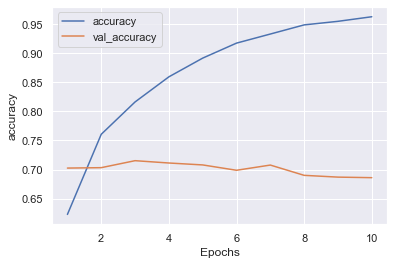

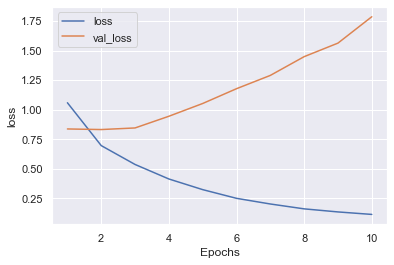

In [239]:
plot_graphs(history_model_bilstm2_em, "accuracy")
plot_graphs(history_model_bilstm2_em, "loss") #epochs = 3

In [71]:
model_bilstm2_em = keras.models.load_model(output_dir+"/weights_bilstm2_em.02.hdf5")

In [129]:
pred_bilstm2_em = np.argmax(model_bilstm2_em.predict(validation_padded), axis = 1)
prf = precision_recall_fscore_support(y[train_cutoff : dev_cutoff], pred_bilstm2_em, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[train_cutoff : dev_cutoff], pred_bilstm2_em)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_bilstm_2_em = np.concatenate((prf,acc), axis = 0)
scores_bilstm_2_em

array([0.72538345, 0.70323189, 0.70827308, 0.70323189])

In [72]:
pred_bilstm2_em_train = np.argmax(model_bilstm2_em.predict(train_padded), axis = 1)
prf = precision_recall_fscore_support(y[0:train_cutoff], pred_bilstm2_em_train, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[0:train_cutoff], pred_bilstm2_em_train)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_bilstm_2_em_train = np.concatenate((prf,acc), axis = 0)
scores_bilstm_2_em_train

array([0.83438478, 0.81865984, 0.82168118, 0.81865984])

In [130]:
results_lstm = pd.DataFrame(index = ['Glove LSTM (1 layer)', 'Glove LSTM (2 layers)',
                                     'Glove Bidirectional LSTM (1 layer)','Glove Bidirectional LSTM (2 layers)',
                                     'Embedding Layer LSTM (1 layer)', 'Embedding Layer LSTM (2 layers)',
                                     'Embedding Layer Bidirectional LSTM (1 layer)',
                                     'Embedding Layer Bidirectional LSTM (2 layers)'], 
          columns = ['Precision', 'Recall', 'F1 score', 'Accuracy'])

In [133]:
results_lstm.iloc[0] = scores_lstm_1
results_lstm.iloc[1] = scores_lstm_2
results_lstm.iloc[2] = scores_bilstm_1
results_lstm.iloc[3] = scores_bilstm_2
results_lstm.iloc[4] = scores_lstm_1_em
results_lstm.iloc[5] = scores_lstm_2_em
results_lstm.iloc[6] = scores_bilstm_1_em
results_lstm.iloc[7] = scores_bilstm_2_em

In [140]:
results_validation = pd.concat([results_lstm,results_traditional], axis = 0).sort_values(['F1 score'], ascending = False)

In [142]:
results_validation

,Precision,Recall,F1 score,Accuracy
SVC - 6000 unigrams + sentiments HP Tuned,0.749515,0.747346,0.747964,0.747346
SVC - 6000 unigrams HP Tuned,0.748636,0.745223,0.746263,0.745223
SVC - 6000 unigrams,0.745792,0.741213,0.742225,0.741213
Glove Bidirectional LSTM (2 layers),0.733034,0.738146,0.728933,0.738146
Embedding Layer Bidirectional LSTM (1 layer),0.726506,0.732484,0.727523,0.732484
Glove LSTM (1 layer),0.724965,0.725407,0.723092,0.725407
Glove LSTM (2 layers),0.726205,0.728002,0.721689,0.728002
Linear SVC - 7000 unigrams,0.718861,0.725879,0.721638,0.725879
Glove Bidirectional LSTM (1 layer),0.723159,0.730361,0.720668,0.730361
Embedding Layer Bidirectional LSTM (2 layers),0.725383,0.703232,0.708273,0.703232


In [73]:
results_lstm_train = pd.DataFrame(index = ['Glove LSTM (1 layer)', 'Glove LSTM (2 layers)',
                                     'Glove Bidirectional LSTM (1 layer)','Glove Bidirectional LSTM (2 layers)',
                                     'Embedding Layer LSTM (1 layer)', 'Embedding Layer LSTM (2 layers)',
                                     'Embedding Layer Bidirectional LSTM (1 layer)',
                                     'Embedding Layer Bidirectional LSTM (2 layers)'], 
          columns = ['Train Precision', 'Train Recall', 'Train F1 score', 'Train Accuracy'])

In [74]:
results_lstm_train.iloc[0] = scores_lstm_1_train
results_lstm_train.iloc[1] = scores_lstm_2_train
results_lstm_train.iloc[2] = scores_bilstm_1_train
results_lstm_train.iloc[3] = scores_bilstm_2_train
results_lstm_train.iloc[4] = scores_lstm_1_em_train
results_lstm_train.iloc[5] = scores_lstm_2_em_train
results_lstm_train.iloc[6] = scores_bilstm_1_em_train
results_lstm_train.iloc[7] = scores_bilstm_2_em_train

In [75]:
results_train = pd.concat([results_train,results_lstm_train],
                               axis = 0).sort_values(['Train F1 score'], ascending = False)

In [76]:
results_train

,Train Precision,Train Recall,Train F1 score,Train Accuracy
Glove Random Forest,0.999124,0.999124,0.999124,0.999124
Random Forest - 2250 unigrams,0.999024,0.999023,0.999023,0.999023
SVC - 6000 unigrams HP Tuned,0.998653,0.998652,0.998652,0.998652
SVC - 6000 unigrams + sentiments HP Tuned,0.998653,0.998652,0.998652,0.998652
Glove SVC Tuned Sentiments,0.977695,0.977653,0.977621,0.977653
Glove SVC Tuned,0.977506,0.97745,0.977418,0.97745
SVC - 6000 unigrams,0.950795,0.950721,0.950487,0.950721
Linear SVC - 7000 unigrams,0.916531,0.916846,0.915966,0.916846
Glove SVC,0.894301,0.894229,0.893731,0.894229
Glove Linear SVC,0.892124,0.893724,0.892475,0.893724


In [82]:
results_validation.columns = ['Val Precision', 'Val Recall', 'Val F1 score', 'Val Accuracy']

In [83]:
full_results = pd.concat([results_train, results_validation], axis = 1).sort_values(['Val F1 score'], ascending = False)

In [86]:
full_results

,Train Precision,Train Recall,Train F1 score,Train Accuracy,Val Precision,Val Recall,Val F1 score,Val Accuracy
SVC - 6000 unigrams + sentiments HP Tuned,0.998653,0.998652,0.998652,0.998652,0.749515,0.747346,0.747964,0.747346
SVC - 6000 unigrams HP Tuned,0.998653,0.998652,0.998652,0.998652,0.748636,0.745223,0.746263,0.745223
SVC - 6000 unigrams,0.950795,0.950721,0.950487,0.950721,0.745792,0.741213,0.742225,0.741213
Glove Bidirectional LSTM (2 layers),0.78919,0.792369,0.783275,0.792369,0.733034,0.738146,0.728933,0.738146
Embedding Layer Bidirectional LSTM (1 layer),0.851624,0.852568,0.849214,0.852568,0.726506,0.732484,0.727523,0.732484
Glove LSTM (1 layer),0.763747,0.763786,0.761425,0.763786,0.724965,0.725407,0.723092,0.725407
Glove LSTM (2 layers),0.770941,0.772381,0.766843,0.772381,0.726205,0.728002,0.721689,0.728002
Linear SVC - 7000 unigrams,0.916531,0.916846,0.915966,0.916846,0.718861,0.725879,0.721638,0.725879
Glove Bidirectional LSTM (1 layer),0.801122,0.802919,0.795638,0.802919,0.723159,0.730361,0.720668,0.730361
Embedding Layer Bidirectional LSTM (2 layers),0.834385,0.81866,0.821681,0.81866,0.725383,0.703232,0.708273,0.703232


### Test Set Scores for Top Five Models

In [145]:
def get_test_scores(model, df): 
    tfidf_model = model
    tfidf_model.fit(df[0 : train_cutoff], labels[0 : train_cutoff])
    tfidf_prediction = tfidf_model.predict(df[dev_cutoff:])
    prf = precision_recall_fscore_support(labels[dev_cutoff:], tfidf_prediction, 
                                                                average = 'weighted', zero_division = True)
    acc = accuracy_score(labels[dev_cutoff:], tfidf_prediction)
    prf = np.array(prf[:3])
    acc = np.array(acc).reshape(1,)
    return np.concatenate((prf,acc), axis = 0)

In [166]:
def get_train_scores(model, df): 
    tfidf_model = model
    tfidf_model.fit(df[0 : train_cutoff], labels[0 : train_cutoff])
    tfidf_prediction = tfidf_model.predict(df[0 : train_cutoff])
    prf = precision_recall_fscore_support(labels[0 : train_cutoff], tfidf_prediction, 
                                                                average = 'weighted', zero_division = True)
    acc = accuracy_score(labels[0 : train_cutoff], tfidf_prediction)
    prf = np.array(prf[:3])
    acc = np.array(acc).reshape(1,)
    return np.concatenate((prf,acc), axis = 0)

In [148]:
svc_hp_sent = get_test_scores(SVC(C=10, gamma=1, kernel = 'rbf'), sentiment_tweets)

In [149]:
svc_hp = get_test_scores(SVC(C=10, gamma=1, kernel = 'rbf'), tfidf_features)

In [150]:
svc = get_test_scores(SVC(), tfidf_features)

In [105]:
# model_bilstm_2 = keras.models.load_model(output_dir+"/weights_bilstm2.03.hdf5")
pred_bilstm_2_test = np.argmax(model_bilstm_2.predict(train_emb[dev_cutoff:]), axis = 1)
prf = precision_recall_fscore_support(y[dev_cutoff:], pred_bilstm_2_test, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[dev_cutoff:], pred_bilstm_2_test)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_bilstm_2_test = np.concatenate((prf,acc), axis = 0)
scores_bilstm_2_test

array([0.72193501, 0.72808777, 0.71935138, 0.72808777])

In [152]:
test_articles = corpus[dev_cutoff:]
test_labels = y[dev_cutoff:]
test_sequences = tokenizer.texts_to_sequences(test_articles)
test_padded = pad_sequences(test_sequences, maxlen=max_length, 
                                  padding=padding_type, truncating=trunc_type)
test_labels = test_labels.reshape(test_padded.shape[0],1)

In [153]:
#model_bilstm1_em = keras.models.load_model(output_dir+"/weights_bilstm1_em.02.hdf5")
pred_bilstm1_em_test = np.argmax(model_bilstm1_em.predict(test_padded), axis = 1)
prf = precision_recall_fscore_support(y[dev_cutoff:], pred_bilstm1_em_test, 
                                                       average = 'weighted', zero_division = True)
acc = accuracy_score(y[dev_cutoff:], pred_bilstm1_em_test)
prf = np.array(prf[:3]) 
acc = np.array(acc).reshape(1,)
scores_bilstm_1_em_test = np.concatenate((prf,acc), axis = 0)
scores_bilstm_1_em_test

array([0.71586535, 0.72289725, 0.71762121, 0.72289725])

['SVC - 6000 unigrams + sentiments HP Tuned',
 'SVC - 6000 unigrams HP Tuned',
 'SVC - 6000 unigrams',
 'Glove Bidirectional LSTM (2 layers)',
 'Embedding Layer Bidirectional LSTM (1 layer)']

In [161]:
results_test = pd.DataFrame(index = list(results_validation.head(5).index), 
          columns = ['Test Precision', 'Test Recall', 'Test F1 score', 'Test Accuracy'])

In [162]:
results_test.iloc[0] = svc_hp_sent
results_test.iloc[1] = svc_hp
results_test.iloc[2] = svc
results_test.iloc[3] = scores_bilstm_2_test
results_test.iloc[4] = scores_bilstm_1_em_test

In [88]:
results_test

,Test Precision,Test Recall,Test F1 score,Test Accuracy
SVC - 6000 unigrams + sentiments HP Tuned,0.742102,0.739413,0.739763,0.739413
SVC - 6000 unigrams HP Tuned,0.738557,0.735166,0.735878,0.735166
SVC - 6000 unigrams,0.737819,0.733868,0.734405,0.733868
Glove Bidirectional LSTM (2 layers),0.721935,0.728088,0.719351,0.728088
Embedding Layer Bidirectional LSTM (1 layer),0.715865,0.722897,0.717621,0.722897


In [91]:
top_five = pd.concat([full_results.head(5), results_test], axis = 1)

In [95]:
top_five

,Train Precision,Train Recall,Train F1 score,Train Accuracy,Val Precision,Val Recall,Val F1 score,Val Accuracy,Test Precision,Test Recall,Test F1 score,Test Accuracy
SVC - 6000 unigrams + sentiments HP Tuned,0.998653,0.998652,0.998652,0.998652,0.749515,0.747346,0.747964,0.747346,0.742102,0.739413,0.739763,0.739413
SVC - 6000 unigrams HP Tuned,0.998653,0.998652,0.998652,0.998652,0.748636,0.745223,0.746263,0.745223,0.738557,0.735166,0.735878,0.735166
SVC - 6000 unigrams,0.950795,0.950721,0.950487,0.950721,0.745792,0.741213,0.742225,0.741213,0.737819,0.733868,0.734405,0.733868
Glove Bidirectional LSTM (2 layers),0.78919,0.792369,0.783275,0.792369,0.733034,0.738146,0.728933,0.738146,0.721935,0.728088,0.719351,0.728088
Embedding Layer Bidirectional LSTM (1 layer),0.851624,0.852568,0.849214,0.852568,0.726506,0.732484,0.727523,0.732484,0.715865,0.722897,0.717621,0.722897


In [113]:
cat_labels_bilstm_2 = pd.DataFrame(pred_bilstm_2_test)[0].map(label_transform)

In [122]:
sentiment_predictions_test = sentiment_svc.predict(sentiment_tweets[dev_cutoff:])


Confusion matrix code adapted from https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'caution_and_advice'),
  Text(1.5, 0, 'sympathy_and_support'),
  Text(2.5, 0, 'harmed_persons_and_evacuations'),
  Text(3.5, 0, 'other_relevant_information'),
  Text(4.5, 0, 'requests_or_urgent_needs'),
  Text(5.5, 0, 'not_humanitarian'),
  Text(6.5, 0, 'infrastructure_and_utility_damage'),
  Text(7.5, 0, 'rescue_volunteering_or_donation_effort')])

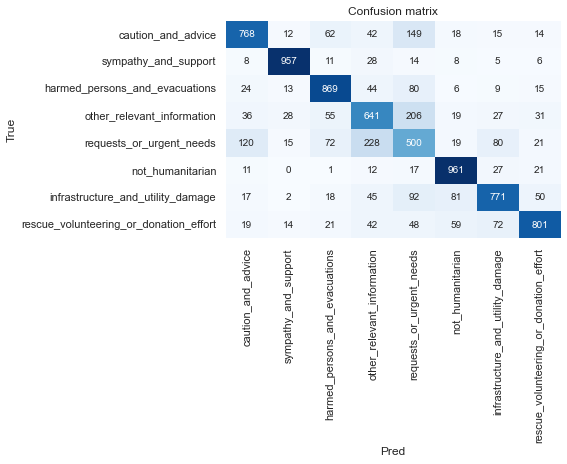

In [123]:
cm = metrics.confusion_matrix(labels[dev_cutoff:], sentiment_predictions_test)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
all_classes = list(pd.DataFrame(resampled_tweets["clean_labels"].value_counts()).index)
ax.set(xlabel="Pred", ylabel="True", xticklabels=all_classes, 
       yticklabels=all_classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'caution_and_advice'),
  Text(1.5, 0, 'sympathy_and_support'),
  Text(2.5, 0, 'harmed_persons_and_evacuations'),
  Text(3.5, 0, 'other_relevant_information'),
  Text(4.5, 0, 'requests_or_urgent_needs'),
  Text(5.5, 0, 'not_humanitarian'),
  Text(6.5, 0, 'infrastructure_and_utility_damage'),
  Text(7.5, 0, 'rescue_volunteering_or_donation_effort')])

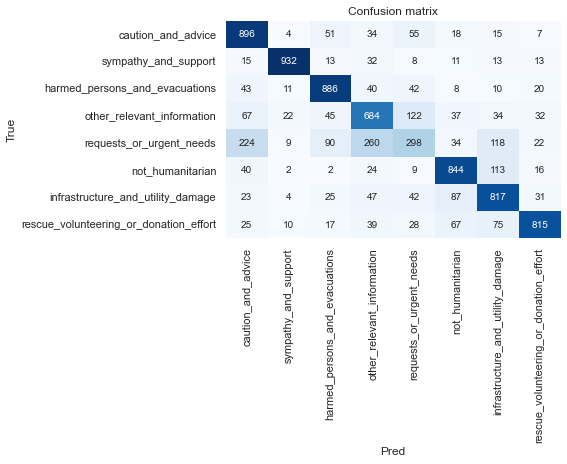

In [124]:
cm_nn = metrics.confusion_matrix(labels[dev_cutoff:], cat_labels_bilstm_2)
fig, ax = plt.subplots()
sns.heatmap(cm_nn, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=all_classes, 
       yticklabels=all_classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)


# References


Agarwal, Rahul. “Using Deep Learning for End to End Multiclass Text Classification.” Medium, 17 Apr. 2020, towardsdatascience.com/using-deep-learning-for-end-to-end-multiclass-text-classification-39b46aecac81.
Ahamed, Sabber. “Text Classification Using LSTM and Visualize Word Embeddings: Part-1.” Medium, 19 Jan. 2021, sabber.medium.com/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b. Accessed 4 May 2022.

Alam, Firoj, et al. “HumAID: Human-Annotated Disaster Incidents Data from Twitter with Deep Learning Benchmarks.” Qatar Computing Research Institute, 2021.

Bambrick, Noel. “Support Vector Machines: A Simple Explanation.” Kdnuggets.com, 2016, www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html.

Brownlee, Jason. “One-Vs-Rest and One-Vs-One for Multi-Class Classification.” Machine Learning Mastery, 12 Apr. 2020, machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/#:~:text=One%2Dvs%2Drest%20(OvR%20for%20short%2C%20also%20referred.

Bujokas, Eligijus. “Text Classification Using Word Embeddings and Deep Learning in Python — Classifying Tweets From….” Analytics Vidhya, 16 Mar. 2020, medium.com/analytics-vidhya/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81. Accessed 4 May 2022.

Cam-Stei, Duncan. “TF-IDF vs Word Embedding, a Comparison and Code Tutorial.” Medium, 19 Feb. 2019, medium.com/@dcameronsteinke/tf-idf-vs-word-embedding-a-comparison-and-code-tutorial-5ba341379ab0.
catris25. “Tweets Cleaning with Python.” Catris Code, 1 May 2021, catriscode.com/2021/05/01/tweets-cleaning-with-python/. Accessed 4 May 2022.

cjhutto. “Cjhutto/VaderSentiment.” GitHub, 19 Dec. 2018, github.com/cjhutto/vaderSentiment.
“CrisisNLP HumAID: Human-Annotated Disaster Incidents Data from Twitter.” Crisisnlp.qcri.org, crisisnlp.qcri.org/humaid_dataset. Accessed 28 Apr. 2022.

“Exploratory Data Analysis for Text Data | EDA Using Python.” Analytics Vidhya, 26 Apr. 2020, www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/#4. Accessed 28 Apr. 2022.
Fraj, Mohtadi Ben. “In Depth: Parameter Tuning for SVC.” Medium, 5 Jan. 2018, medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769.

Gandhi, Rohith. “Support Vector Machine — Introduction to Machine Learning Algorithms.” Medium, 5 July 2018, towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47#:~:text=Support%20vector%20machine%20is%20highly. Accessed 28 Apr. 2022.

Gautam, Akash Kumar, et al. “Multimodal Analysis of Disaster Tweets.” 2019 IEEE Fifth International Conference on Multimedia Big Data (BigMM), Sept. 2019, 10.1109/bigmm.2019.00-38. Accessed 28 Apr. 2022.

Holtz, Yan. “Grouped, Stacked and Percent Stacked Barplot in Ggplot2.” Www.r-Graph-Gallery.com, r-graph-gallery.com/48-grouped-barplot-with-ggplot2.html.

“How to Reorder Bars in Barplot with Ggplot2 in R.” Data Viz with Python and R, 23 Dec. 2019, datavizpyr.com/re-ordering-bars-in-barplot-in-r/. Accessed 28 Apr. 2022.

Huilgol, Purva. “Accuracy vs. F1-Score.” Medium, 24 Aug. 2019, medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2.

Joshi, Prathap Manohar. “Generative vs Discriminative Models.” Medium, 1 Sept. 2018, medium.com/@mlengineer/generative-and-discriminative-models-af5637a66a3. Accessed 28 Apr. 2022.

Kamyab, Marjan, et al. “Attention-Based CNN and Bi-LSTM Model Based on TF-IDF and GloVe Word Embedding for Sentiment Analysis.” Applied Sciences, vol. 11, no. 23, 27 Nov. 2021, p. 11255, 10.3390/app112311255. Accessed 30 Dec. 2021.

Kar, Shantam. “Naïve Bayes vs. SVM for Text Classification.” Analytics Vidhya, 7 Jan. 2021, medium.com/analytics-vidhya/na%C3%AFve-bayes-vs-svm-for-text-classification-c63478229c33.

Korab, Petr. “The Most Favorable Pre-Trained Sentiment Classifiers in Python.” Medium, 18 Feb. 2022, towardsdatascience.com/the-most-favorable-pre-trained-sentiment-classifiers-in-python-9107c06442c6. Accessed 4 May 2022.

Li, Susan. “Multi Class Text Classification with LSTM Using TensorFlow 2.0.” Medium, 8 Dec. 2019, towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35.

“Matplotlib Histograms.” Www.w3schools.com, www.w3schools.com/python/matplotlib_histograms.asp.

“NLP  GloVe, BERT, TF-IDF, LSTM...  Explained.” Kaggle.com, www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained/notebook#5.2-TF-IDF. Accessed 4 May 2022.

“Order Bars of Ggplot2 Barchart in R (4 Examples) | How to Sort Manually.” Statistics Globe, statisticsglobe.com/ordered-bars-in-ggplot2-barchart-in-r.

Pietro, Mauro Di. “Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT.” Medium, 18 July 2020, towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794.

Potts, Christopher. “Sentiment Symposium Tutorial: Classifiers.” Christopherpotts.net, 2010, sentiment.christopherpotts.net/classifiers.html. Accessed 8 July 2019.

“Proportions with Dplyr Package in R (Example) | Relative Frequency Table.” Statistics Globe, statisticsglobe.com/relative-frequencies-with-dplyr-package-in-r. Accessed 28 Apr. 2022.

“Python | Stemming Words with NLTK.” GeeksforGeeks, 30 Oct. 2018, www.geeksforgeeks.org/python-stemming-words-with-nltk/.

Raschka, Sebastian. “What Is the Major Difference between Naive Bayes and Logistic Regression?” Dr. Sebastian Raschka, 25 Apr. 2022, sebastianraschka.com/faq/docs/naive-bayes-vs-logistic-regression.html. Accessed 28 Apr. 2022.

Rul, Céline Van den. “How to Generate Word Clouds in R.” Medium, 20 Oct. 2019, towardsdatascience.com/create-a-word-cloud-with-r-bde3e7422e8a.

“Sentiment_by: Polarity Score (Sentiment Analysis) by Groups in Sentimentr: Calculate Text Polarity Sentiment.” Rdrr.io, rdrr.io/cran/sentimentr/man/sentiment_by.html.

Shah, Parthvi. “Basic Tweet Preprocessing in Python.” Medium, 7 June 2020, towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e.

Simha, Anirudha. “Understanding TF-IDF for Machine Learning.” Capital One, 2021, www.capitalone.com/tech/machine-learning/understanding-tf-idf/.

So, Geoffrey. “Should We Abandon LSTM for CNN?” AI/ML at Symantec, 30 Mar. 2019, medium.com/ai-ml-at-symantec/should-we-abandon-lstm-for-cnn-83accaeb93d6#:~:text=An%20LSTM%20is%20designed%20to.

Son, Jaebong, et al. “Understanding the Uncertainty of Disaster Tweets and Its Effect on Retweeting: The Perspectives of Uncertainty Reduction Theory and Information Entropy.” Journal of the Association for Information Science and Technology, vol. 71, no. 10, 24 Dec. 2019, pp. 1145–1161, 10.1002/asi.24329. Accessed 26 Apr. 2021.

Stecanella, Bruno. “What Is TF-IDF?” MonkeyLearn Blog, 10 May 2019, monkeylearn.com/blog/what-is-tf-idf/.

Stowe, Kevin, et al. “Identifying and Categorizing Disaster-Related Tweets.” Proceedings of the Fourth International Workshop on Natural Language Processing for Social Media, 2016, 10.18653/v1/w16-6201. Accessed 28 Apr. 2022.
“SVM Hyperparameter Tuning Using GridSearchCV | ML.” GeeksforGeeks, 5 July 2019, www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/.

Theiler, Sebastian. “Basics of Using Pre-Trained GloVe Vectors in Python.” Analytics Vidhya, 28 Nov. 2021, medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db.

Varga, István, et al. “Aid Is out There: Looking for Help from Tweets during a Large Scale Disaster.” Proceedings of the 51st Annual Meeting of the Association for Computational Linguistics, vol. 1, Aug. 2013, pp. 1619–1629. Association for Computational Linguistics.

Varghese, Danny. “Comparative Study on Classic Machine Learning Algorithms.” Medium, 10 May 2019, towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222.

Verma, Yugesh. “Complete Guide to Bidirectional LSTM (with Python Codes).” Analytics India Magazine, 17 July 2021, analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/#:~:text=In%20bidirectional%2C%20our%20input%20flows. Accessed 28 Apr. 2022.

Vij, Yatin. “Combining Word Embeddings to Form Document Embeddings.” Analytics Vidhya, 25 Sept. 2019, medium.com/analytics-vidhya/combining-word-embeddings-to-form-document-embeddings-9135a66ae0f. Accessed 4 May 2022.

Wasser, Leah, and Carson Farmer. “Text Mining Twitter Data with TidyText in R.” Earth Data Science - Earth Lab, 19 Apr. 2017, www.earthdatascience.org/courses/earth-analytics/get-data-using-apis/text-mining-twitter-data-intro-r/. Accessed 28 Apr. 2022.
